# Segemntacja za pomocą k-Średnich po feature engineeringu za pomocą analizy RFM.

## Usunięcie wierszy z pustymi wartościami i zapisanie go jako osobny dataframe i plik .csv
Usunięcie prawie 16 mln wierszy z brakami pozwoliło na zmniejszenie rozmairu zbioru o ponad 1.5 GB 
```
df = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/archive/2019-Oct.csv")
df.info(show_counts=True)
df_clean = df.dropna(axis=0, how='any').reset_index(drop=True)
df_clean.info(show_counts=True)
df_clean.to_csv('/content/drive/MyDrive/Colab Notebooks/archive/2019-Oct_clean.csv')
```


In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from datetime import datetime
import re, seaborn as sns
import plotly.express as px

from sklearn.cluster import KMeans 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances

sns.set(rc={'figure.figsize':(12, 8)})
sns.set_style('ticks')

Załadowanie wyczyszczonego data frame'u

In [2]:
df = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/archive/2019-Oct_clean.csv", index_col=0)

In [3]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26560620 entries, 0 to 26560619
Data columns (total 9 columns):
 #   Column         Non-Null Count     Dtype  
---  ------         --------------     -----  
 0   event_time     26560620 non-null  object 
 1   event_type     26560620 non-null  object 
 2   product_id     26560620 non-null  int64  
 3   category_id    26560620 non-null  int64  
 4   category_code  26560620 non-null  object 
 5   brand          26560620 non-null  object 
 6   price          26560620 non-null  float64
 7   user_id        26560620 non-null  int64  
 8   user_session   26560620 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 2.0+ GB


In [4]:
df

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
1,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
2,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d
3,2019-10-01 00:00:05 UTC,view,1480613,2053013561092866779,computers.desktop,pulser,908.62,512742880,0d0d91c2-c9c2-4e81-90a5-86594dec0db9
4,2019-10-01 00:00:10 UTC,view,28719074,2053013565480109009,apparel.shoes.keds,baden,102.71,520571932,ac1cd4e5-a3ce-4224-a2d7-ff660a105880
...,...,...,...,...,...,...,...,...,...
26560615,2019-10-31 23:59:58 UTC,view,1004870,2053013555631882655,electronics.smartphone,samsung,275.25,518956209,6764041a-9285-4869-8a32-a79adf31d212
26560616,2019-10-31 23:59:58 UTC,view,2702331,2053013563911439225,appliances.kitchen.refrigerators,lg,527.43,524356542,153f9818-4d32-4e8b-ba9f-f355094e8ae4
26560617,2019-10-31 23:59:58 UTC,view,2300275,2053013560530830019,electronics.camera.video,gopro,527.40,537931532,22c57267-da98-4f28-9a9c-18bb5b385193
26560618,2019-10-31 23:59:58 UTC,view,5701038,2053013553970938175,auto.accessories.player,kenwood,128.70,566280422,05b6c62b-992f-4e8e-91f7-961bcb4719cd


In [5]:
df['price'].min()

0.88

### Feature enginnering with RFM

Wzięcie tylko `event_type` == `purchase`. Stworzenie kolumny zawierającej `recency`. Policzenie liczby zakupów wg. `user_session` oraz sumy wydanych pieniędzy przez użytkownika `price`.

In [6]:
df_rfm = df.loc[df['event_type'] == 'purchase']

# wycięcie pierwszych 10 znaków i zmiana na datetime
df_rfm['event_time'] = df_rfm['event_time'].apply(lambda s: str(s)[0:10])
df_rfm['event_time'] = pd.to_datetime(df_rfm['event_time'], format='%Y-%m-%d')

#usunięcie kolumny z dodatkowym indexem
df_rfm = df_rfm.loc[:,~df_rfm.columns.str.match("Unnamed")]

# recency od ostatniego zakupu w zbiorze
max_date = df_rfm['event_time'].max()
df_rfm = df_rfm.groupby(['user_id']).agg({'event_time': lambda x : (max_date - x.max()).days,'user_session':'count','price': 'sum'})
df_rfm

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,event_time,user_session,price
user_id,,,
303160429,18,1,340.59
340041246,17,1,339.70
384989212,13,1,41.44
401021311,10,1,231.64
403013066,13,2,807.16
...,...,...,...
566265448,0,1,592.01
566267483,0,2,30.74
566270060,0,2,147.42


Zmiana nazw kolumn.

In [7]:
df_rfm.rename(columns={'event_time':'recency','user_session':'frequency','price':'monetary'}, inplace=True)
df_rfm

,recency,frequency,monetary
user_id,,,
303160429,18,1,340.59
340041246,17,1,339.70
384989212,13,1,41.44
401021311,10,1,231.64
403013066,13,2,807.16
...,...,...,...
566265448,0,1,592.01
566267483,0,2,30.74
566270060,0,2,147.42


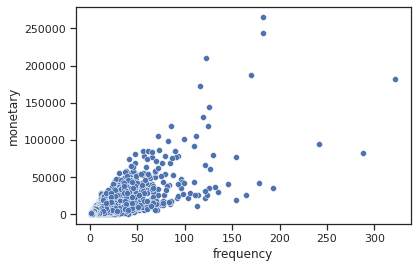

In [8]:
sns.scatterplot(x='frequency', y='monetary', data=df_rfm)
plt.show()

Usunięcie wartości skrajnych

In [9]:
# df_rfm_nout = df_rfm.loc[(df_rfm['frequency'] < 200) & (df_rfm['monetary'] < 150000)]
df_rfm_nout = df_rfm

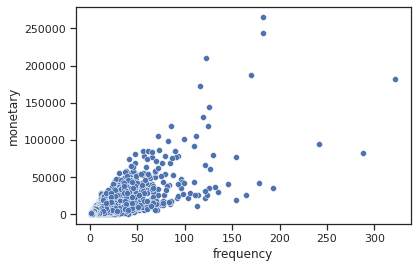

In [10]:
sns.scatterplot(x='frequency', y='monetary', data=df_rfm_nout)
plt.show()

Feature enginnering za pomoca RFM

Standaryzacja

In [11]:
standard_scaler = StandardScaler()
df_rfm_nout_stan = pd.DataFrame(standard_scaler.fit_transform(df_rfm_nout), columns = df_rfm_nout.columns)

## Wyznaczenie liczby `k`

In [12]:
# silhouette score
kmeans_per_k = [KMeans(n_clusters=k).fit(df_rfm_nout_stan)
                for k in range(2, 8)]
silhouette_scores = [silhouette_score(df_rfm_nout_stan, model.labels_)
                     for model in kmeans_per_k]

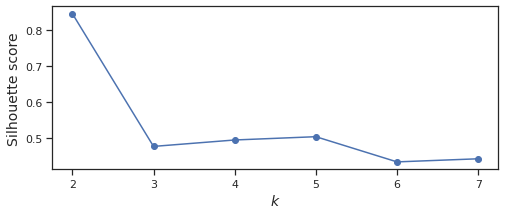

In [13]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 8), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

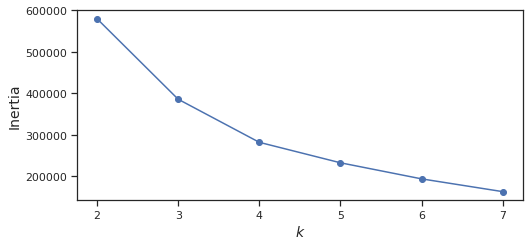

In [14]:
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(2, 8), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.show()

### Model i wizualizacje dla 3 klastrów

In [12]:
clusterNum = 3
k_means = KMeans(init="k-means++", n_clusters=clusterNum, n_init=30)
k_means.fit(df_rfm_nout_stan)
labels = k_means.labels_
df_rfm_nout["clusters_3"] = labels
df_rfm_nout = df_rfm_nout.sort_values("clusters_3")
df_rfm_nout

,recency,frequency,monetary,clusters_3
user_id,,,,
536585624,13,1,127.81,0
543190384,5,1,421.81,0
543191263,3,1,276.00,0
543191334,9,3,394.08,0
543191647,8,3,427.14,0
...,...,...,...,...
520401702,0,16,16107.26,2
512654674,5,48,32546.30,2
532623747,0,28,10690.01,2


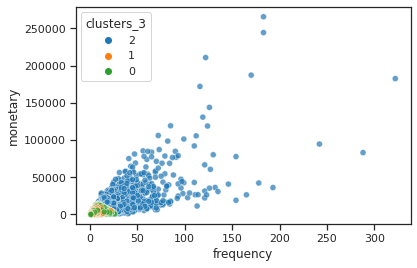

In [21]:
df_rfm_nout['clusters_3'] = df_rfm_nout["clusters_3"].astype(str)
sns.scatterplot(x='frequency', y='monetary', data=df_rfm_nout, hue='clusters_3', 
                hue_order=["2", "1", "0"], palette='tab10', alpha=0.7)
plt.show()

In [14]:
df_rfm_nout.groupby('clusters_3')['monetary'].describe()

,count,mean,std,min,25%,50%,75%,max
clusters_3,,,,,,,,
0,137055.0,816.250209,1285.744294,0.88,160.620,353.37,923.560,13951.12
1,124515.0,481.908349,682.911036,0.88,131.760,251.49,553.405,14301.99
2,1875.0,17062.265701,17756.483444,864.49,8862.145,12979.18,18820.640,265569.52


In [15]:
fig = px.scatter_3d(df_rfm_nout, x='recency', y='frequency', z='monetary',
                    color='clusters_3', opacity=0.7)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
df_rfm_nout.to_csv(r"/content/drive/MyDrive/Colab Notebooks/archive/2019-Oct_clean_with_segments.csv")

### Model i wizualizacje dla 4 klastrów

In [16]:
clusterNum = 4
k_means = KMeans(init="k-means++", n_clusters=clusterNum, n_init=30)
k_means.fit(df_rfm_nout_stan)
labels = k_means.labels_
df_rfm_nout["clusters_4"] = labels
df_rfm_nout = df_rfm_nout.sort_values("clusters_4")

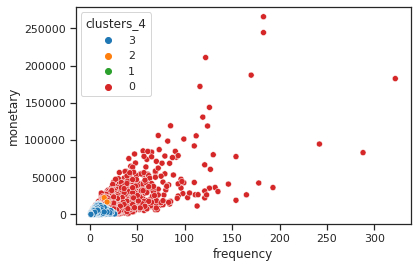

In [18]:
df_rfm_nout['clusters_4'] = df_rfm_nout["clusters_4"].astype(str)
sns.scatterplot(x='frequency', y='monetary', data=df_rfm_nout, hue='clusters_4', 
                hue_order=[ "3", "2", "1", "0"], palette='tab10')
plt.show()

In [19]:
df_rfm_nout.groupby('clusters_4')['monetary'].describe()

,count,mean,std,min,25%,50%,75%,max
clusters_4,,,,,,,,
0,138811.0,873.216367,2986.719180,0.88,147.18,289.55,745.58,265569.52
1,193.0,696.959067,1229.036065,8.67,159.91,342.23,722.14,9122.95
2,5941.0,663.919758,1137.047796,3.69,143.64,283.12,727.69,22495.08
3,118500.0,663.095706,1066.156222,0.88,144.12,286.84,732.09,13941.78


In [20]:
fig = px.scatter_3d(df_rfm_nout, x='recency', y='frequency', z='monetary',
                    color='clusters_4', opacity=0.7)
fig.show()

Output hidden; open in https://colab.research.google.com to view.